In [1]:
import os

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.set_cmap('jet')
%matplotlib inline

import collections
import numpy as np
import random
import sklearn, sklearn.model_selection
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as Data
import torchvision


In [2]:
random.seed(1234)
np.random.seed(1234)

torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

torch.cuda.manual_seed_all(1234)

In [3]:
BATCH_SIZE = 64

In [5]:
if not os.path.isdir("./cyclegan/results-train/brats2013-trainB"):
    # make dataset with 700 samples of each type
    !mkdir ./cyclegan/results-train/brats2013-trainB/False
    !mkdir ./cyclegan/results-train/brats2013-trainB/True
    # 0% tumor
    !cp -r ./cyclegan/results-train/brats2013_cyclegan_0.0/test_latest/images/*_real_B.png ./cyclegan/results-train/brats2013-trainB/False
    # 100% tumor
    !cp -r ./cyclegan/results-train/brats2013_cyclegan_1.0/test_latest/images/*_real_B.png ./cyclegan/results-train/brats2013-trainB/True


In [7]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(
    './cyclegan/results-train/brats2013-trainB',
    transform=mytransform)


In [8]:
print '# of examples: ', len(data)

# of examples:  1400


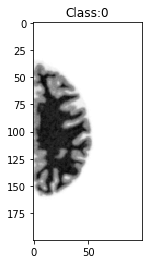

In [18]:
plt.imshow(data[100][0][0].numpy(), cmap='Greys')
plt.title('Class:' + str(data[100][1]))
plt.show()


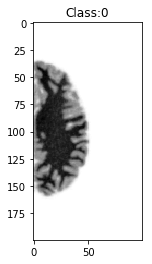

In [19]:
plt.imshow(data[0][0][0].numpy(), cmap='Greys')
plt.title('Class:' + str(data[0][1]))
plt.show()


In [11]:
tosplit = np.asarray(data.imgs)[:, 1]
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(
    idx, stratify=tosplit, train_size=0.75, random_state=0)


In [12]:
print('train_idx', len(train_idx))
print('valid_idx', len(valid_idx))


('train_idx', 1050)
('valid_idx', 350)


In [13]:

train_loader = torch.utils.data.DataLoader(
    dataset=data, batch_size=BATCH_SIZE,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(
    dataset=data, batch_size=len(valid_idx),
    sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx))


In [14]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0])
valid_y = valid_data[0][1]


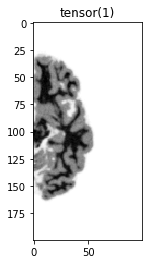

In [20]:
plt.imshow(valid_x[70][0].data.numpy(), cmap='Greys')
plt.title(valid_y[70])
plt.show()


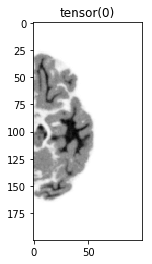

In [21]:
plt.imshow(valid_x[2][0].data.numpy(), cmap='Greys')
plt.title(valid_y[2])
plt.show()


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x


In [22]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [23]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()


In [ ]:
for epoch in range(200):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):

        b_x = Variable(x)
        b_y = Variable(y)

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.data[0])

    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = sum(pred_y == valid_y).item() / float(valid_y.size(0))
    print(
        'Epoch: ', epoch,
        '| train loss: %.4f' % np.asarray(batch_loss).mean(),
        '| valid accuracy: %.2f' % accuracy)


/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


('Epoch: ', 0, '| train loss: 0.6928', '| valid accuracy: 0.60')
('Epoch: ', 1, '| train loss: 0.6844', '| valid accuracy: 0.60')
('Epoch: ', 2, '| train loss: 0.6628', '| valid accuracy: 0.55')
('Epoch: ', 3, '| train loss: 0.6585', '| valid accuracy: 0.62')
('Epoch: ', 4, '| train loss: 0.6414', '| valid accuracy: 0.61')
('Epoch: ', 5, '| train loss: 0.6221', '| valid accuracy: 0.63')
('Epoch: ', 6, '| train loss: 0.5969', '| valid accuracy: 0.70')
('Epoch: ', 7, '| train loss: 0.5672', '| valid accuracy: 0.00')
('Epoch: ', 8, '| train loss: 0.5491', '| valid accuracy: 0.02')
('Epoch: ', 9, '| train loss: 0.5393', '| valid accuracy: 0.01')
('Epoch: ', 10, '| train loss: 0.5192', '| valid accuracy: 0.70')


In [ ]:
# torch.save(cnn.state_dict(), './classifier_model.pth')


In [ ]:
checkpoint = torch.load('./classifier_model.pth')
cnn.load_state_dict(checkpoint)


In [ ]:
cnn.eval()


In [ ]:
test_output, last_layer = cnn(valid_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
print('valid accuracy: %.2f' % accuracy)
